Our first approach is to generate, by hand, a simple collections of sentences organised by intents and associated answers.
We will then process that data to make it suitable for NLP applications, encode it using "bag of word" and train a neural network to predict user intent from an utterance.

Then, we wil used pre-trained word embeddings

Then, we will generate training data using OpenAI GPT-3 API and train it, using both bag of words and word embeddings
We can also try TF-IDF to compare it with the NN.

# Import / Generate data

In [1]:
import json

import numpy as np
import pandas as pd
from sklearn import tree, svm, naive_bayes
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
from time import time
from collections import defaultdict
import spacy
from spacy.tokens import DocBin
nlp = spacy.load("en_core_web_lg")

In [2]:
data_file = open('intents.json').read()
intents = json.loads(data_file)


data = []
for intent in intents['intents']:
    for pattern in intent['patterns']:
        data.append([pattern, intent['tag']])

df = pd.DataFrame(data, columns=['text','intent'])

# Data pre-processing

In [3]:
# fine-tune preprocessing for spaCy word embeddings using this method : https://www.kaggle.com/code/christofhenkel/how-to-preprocessing-when-using-embeddings

In [4]:
# Helper functions

def lemmatize_text(text, preprocessed=True):
    return process_text(text, "lemmatize", preprocessed)

def tokenize_text(text, preprocessed=True):
    return process_text(text, "tokenize", preprocessed)

def process_text(text, mode: str, preprocessed=True):
    if not preprocessed:
        text = nlp(text)
    if mode == "tokenize":
        processed_text = [token for token in text] # token and embed must have the same processing + SpaCy provides embeddings for punctuation
    elif mode == "embed":
        processed_text = [token.vector for token in text] # token and embed must have the same processing
    elif mode == "lemmatize":
        processed_text = [token.lemma_ for token in text
                               if not token.is_punct and not token.is_space and not token.like_url and not token.like_email]
    else:
        raise ValueError("Mode not supported")
    return processed_text

def save_preprocessed(raw_text, save_path):
    doc_bin = DocBin(attrs=["LEMMA", "ENT_IOB", "ENT_TYPE"], store_user_data=True)
    for doc in nlp.pipe(raw_text):
        doc_bin.add(doc)
    # save DocBin to a file on disc
    doc_bin.to_disk(save_path)

In [5]:
file_name_spacy = 'preprocessed_documents.spacy'
#save_preprocessed(raw_text=df["text"], save_path="preprocessed_documents.spacy")

# Load DocBin at later time or on different system from disc or bytes object
doc_bin = DocBin().from_disk(file_name_spacy)
df["doc"] = list(doc_bin.get_docs(nlp.vocab))

# Data preparation

In [6]:
X_train = df["doc"]
y_train = df["intent"]

vectorizer = TfidfVectorizer(ngram_range=(1, 1), lowercase=False, tokenizer=tokenize_text, max_features=3000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_embedded = df["doc"].apply(process_text, args=("embed", True,))
X_train_embedded_avg = X_train_embedded.apply(sum).apply(pd.Series)

# The following code block construct a sentence representation as a sum of all embeddings of the words in it, weighted by their tfidf score

result = []
for (idxRow, sentence) in X_train.items():
    final = 0
    for idxWord, word in enumerate(sentence):
        tfidf_idx = vectorizer.vocabulary_[word]
        final += (X_train_tfidf.toarray())[idxRow][tfidf_idx] * X_train_embedded[idxRow][idxWord]
    result.append(final)

X_train_embedded_avg_tfidf = pd.Series(result).apply(pd.Series)

# Models preparation

In [7]:
vect = TfidfVectorizer(lowercase=False, tokenizer=lemmatize_text, max_features=3000)

# classifiers to use

# TODO : implement more classifiers

gs_dict_tfidf = defaultdict(dict)

dectree = tree.DecisionTreeClassifier()
svm_clf = svm.SVC()
multi_nb = naive_bayes.MultinomialNB() # Not suitable for negative values (thus not suitable for word embeddings)

gs_dict_tfidf['dectree']['pipeline'] = Pipeline([
    ('vect', vect),
    ('dectree', dectree)])
gs_dict_tfidf['svm_clf']['pipeline'] = Pipeline([
    ('vect', vect),
    ('svm_clf', svm_clf)])
gs_dict_tfidf['multi_nb']['pipeline'] = Pipeline([
    ('vect', vect),
    ('multi_nb', multi_nb)])

gs_dict_tfidf['dectree']['params'] = {
    "dectree__max_depth": [4, 40],
    "vect__ngram_range": ((1, 1), (1, 2), (1,3), (1,4)),
    "vect__use_idf": (True, False),
    "vect__binary": (True, False),
}
gs_dict_tfidf['svm_clf']['params'] = {
    "svm_clf__kernel": ["linear", "rbf"],
    "vect__ngram_range": ((1, 1), (1, 2), (1,3), (1,4)),
    "vect__use_idf": (True, False),
    "vect__binary": (True, False),
}
gs_dict_tfidf['multi_nb']['params'] = {
    "multi_nb__alpha": [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000],
    "vect__ngram_range": ((1, 1), (1, 2), (1,3), (1,4)),
    "vect__use_idf": (True, False),
    "vect__binary": (True, False),
}

^Classic below : WORD EMBEDDINGS

In [8]:
gs_dict_embeddings = defaultdict(dict)
# classifiers to use
dectree = tree.DecisionTreeClassifier()
svm_clf = svm.SVC()

gs_dict_embeddings['dectree']['pipeline'] = Pipeline([
    ('dectree', dectree)])
gs_dict_embeddings['svm_clf']['pipeline'] = Pipeline([
    ('svm_clf', svm_clf)])

gs_dict_embeddings['dectree']['params'] = {
    "dectree__max_depth": [4, 10],
}
gs_dict_embeddings['svm_clf']['params'] = {
    "svm_clf__kernel": ["linear", "rbf"],
}

# Model Selection

In [9]:
# Helper functions

def perform_grid_search(X_train, y_train, pipeline, parameters, scoring):
    gs_clf = GridSearchCV(pipeline, parameters, n_jobs=1, verbose=1, cv=3, scoring=scoring) # Issue when n_jobs = -1 OR > 1
    # I believe this may be because we use a custom tokenizer in TfidfVectorizer(), can't find how to solve it
    print("\n------------------------------------------------------------------------\n")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()

    gs_clf.fit(X_train, y_train)

    print("\nDone in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % gs_clf.best_score_)
    print("Best parameters set:")
    best_parameters = gs_clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(f"\t'{param_name}': '{best_parameters[param_name]}'")
    return gs_clf

def best_estimator_per_clf(X_train, y_train, gs_dict: defaultdict, scoring):
    for clf in dict(gs_dict):
        gs_dict[clf]['gs'] = perform_grid_search(
            X_train,
            y_train,
            gs_dict[clf]['pipeline'],
            gs_dict[clf]['params'],
            scoring
        )

Traditional classifiers cannot accept as input a sequence of word embeddings, so we try 2 strategies :
- Averaging all embeddings in a sentence
- Averaging using TF-IDF score as weight

In [10]:
best_estimator_per_clf(X_train_embedded_avg_tfidf, y_train, gs_dict_embeddings, scoring="accuracy")

# TODO : Use random state in gsCV and XGBoost for reporductibility

# TODO : XGBoost, feature importance

# TODO : implement multiple scoring : https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

# TODO : extract metrics https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py


------------------------------------------------------------------------

pipeline: ['dectree']
parameters:
{'dectree__max_depth': [4, 10]}
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Done in 0.043s

Best score: 0.427
Best parameters set:
	'dectree__max_depth': '10'

------------------------------------------------------------------------

pipeline: ['svm_clf']
parameters:
{'svm_clf__kernel': ['linear', 'rbf']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Done in 0.034s

Best score: 0.739
Best parameters set:
	'svm_clf__kernel': 'linear'


In [11]:
test = sum(process_text(nlp("I want to print 76 page of a document"), mode="embed"))

In [12]:
model = gs_dict_embeddings['svm_clf']['gs'].best_estimator_
model.predict([test])

array(['printing_request'], dtype=object)

# Model evaluation

idea : skew text classification if name entities are found (either by multiple channels NN or by adding a feature to the data passed)

In [13]:
# LSTM : https://www.tensorflow.org/text/tutorials/text_classification_rnn
len(nlp.vocab.vectors.keys())

684830

In [28]:
import tensorflow as tf

max_words = 30 # Max number of words in a sentence

raw_inputs = X_train_embedded
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    X_train_embedded,
    maxlen=max_words,
    padding="post",
    truncating="pre",
    dtype="float32",
)

In [62]:
padded_inputs.shape

(31, 30, 300)

In [35]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Input, Masking
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_train)
number_classes = len(y_train.unique())

model=Sequential()
#model.add(Embedding(vocab_size,300,input_length=max_words))
model.add(Masking(mask_value=0, input_shape=(None, 300)))
model.add(LSTM(units=128,
               return_sequences=False,
               input_shape=(None, 300)
               ))
model.add(Dense(number_classes, activation='softmax'))

print(model.summary())
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(tf.convert_to_tensor(padded_inputs), y_encoded, epochs=10)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_5 (Masking)         (None, None, 300)         0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               219648    
                                                                 
 dense_5 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 220,680
Trainable params: 220,680
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 2.1212 - accuracy: 0.0323
Epoch 2/10
1/1 [==============================] - 0s 192ms/step - loss: 1.9880 - accuracy: 0.2258
Epoch 3/10
1/1 [==============================] - 0s 135ms/step - loss: 1.8656 - accuracy: 0.6129
Epoch 4/10
1/1 [

In [75]:
test = process_text("This is a printing request for a super cool document", mode="embed", preprocessed=False)
predict = model.predict(np.asarray([test]))
# le.inverse_transform(predict)
le.inverse_transform([6])

array(['printing_request'], dtype=object)

In [ ]:
# Makes no sense to train LSTM / CNN on Tf-Idf : They preserve spatial / temporal information, but that information is lost with tfidf
# Does not play to their strength, not more relevant than a classic classifier

KeyError: 'val_loss'

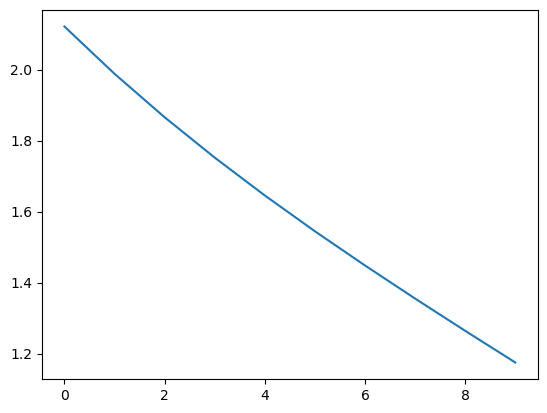

In [41]:
# Helper function

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plot_graphs(history, "loss")

In [ ]:
# Use party one to implement a CNN

In [ ]:
# Tes with matrix embedding based solely on my vocab or on the whole spacy vocab